In [87]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [88]:
files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*")) #filepath for multi, this is a directory containing directories.
data = []
for i, dir in enumerate(files):
    set = dict(images = [], header = None, template = None, refs = None, WCS = None, run = i) #dictionary object used to sort input files
    images = sorted(glob.glob(dir+'/*')) # formatting
    print(dir)
    hdus = [fits.open(i) for i in images] #opens fits files
    frames = [h[1].data for h in hdus] #image data
    header = (hdus[0])[1].header #the header for each run is the header for the first image, you don't need each individual header.
    try: #some datsets won't align, this is not ideal but we can skip alignment.
        aligned = [aa.register(i, frames[0])[0] for i in frames[0:]] #align takes quite a while, is there a way to make it faster?
    except:
        aligned = frames
        print("DID NOT ALIGN")

    template = np.median(aligned, axis = 0) #creates median value template
    w = WCS(hdus[0][1].header) #WCS matrix object, used to transform pixel values to RA-DEC coordinates


    #Fills out set object
    set['images'] = aligned
    set['header'] = header
    set['template'] = template
    set['WCS'] = w
    bkg_phot = sep.Background(template) #background subtract for source extraction.
    set['refs'] = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image
     #this ensures that the source list is the same for all sets
    set['run'] = i
    print(len(set['refs'])) #check
    data.append(set)
#added


/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r


Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


81
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r


Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


71
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r
64
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_07r
71
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_08r
69
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_09r
63
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r
70


In [89]:
print(len(data)) #check

7


In [90]:
#This section access SDSS to collect reference magnitudes for our sources.

sources = []
n_ref = 0 #check counter
filter = 'r' #observation filter
for c, src in enumerate(data[0]['refs']): #looking at the sources picked out in the first run so that everything is with respect to one source list.
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, data[0]['WCS']).transform_to('icrs') #gives wcs transformation for pixel coordinates
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_{}'.format(filter), 'psfMagErr_{}'.format(filter)], radius = 15 * u.arcsec, region = False) #narrow field cone search to find source based on ra, dec.
    radius = (src['xmax']-src['xmin'])/2
    ref = dict(ra_dec = coord, source_id = c, rad = radius, ref_mag = None, ref_mag_err = None, border = False) #because the pixel value isn't static across observing runs, don't save the x-y values just ra dec and convert later.
    for i in range(0, len(data)): #creates mag slots for each observing run
        ref['calibrated_mags_{}'.format(i)] = [] #even though the calibrated mags should line up (and not need to be separated) this is to help visualize day changes later on
        ref['instrumental_mags_{}'.format(i)] = []
        ref['inst_mag_errs_{}'.format(i)] = []
    if search: #if SDSS query returned results, continue
        if search['type'] == 'STAR': #filters search results by sources that of type star.
            ref['ref_mag'] = search['psfMag_{}'.format(filter)] #add reference mag
            ref['ref_mag_err'] = search['psfMagErr_{}'.format(filter)] #add SDSS error
            n_ref += 1
    sources.append(ref)
print(n_ref)
#added

29


In [91]:
print(sources[0]) #just to check everything is there.
print(len(data[0]))

{'ra_dec': <SkyCoord (ICRS): (ra, dec) in deg
    (210.78272351, 54.45971846)>, 'source_id': 0, 'rad': 5.0, 'ref_mag': None, 'ref_mag_err': None, 'border': False, 'calibrated_mags_0': [], 'instrumental_mags_0': [], 'inst_mag_errs_0': [], 'calibrated_mags_1': [], 'instrumental_mags_1': [], 'inst_mag_errs_1': [], 'calibrated_mags_2': [], 'instrumental_mags_2': [], 'inst_mag_errs_2': [], 'calibrated_mags_3': [], 'instrumental_mags_3': [], 'inst_mag_errs_3': [], 'calibrated_mags_4': [], 'instrumental_mags_4': [], 'inst_mag_errs_4': [], 'calibrated_mags_5': [], 'instrumental_mags_5': [], 'inst_mag_errs_5': [], 'calibrated_mags_6': [], 'instrumental_mags_6': [], 'inst_mag_errs_6': []}
6


In [92]:
for set in data:
    print(set['run'])
    for i, image in enumerate(set['images']):
        print(i)
        N_r = set['header']['RDNOISE'] #readout noise
        for source in sources:
            coords = SkyCoord.to_pixel(source['ra_dec'], wcs = set['WCS']) #gets pixel values of source from RA DEC
            #print(coords[0], coords[1])
            if (set['header']['NAXIS1'] - coords[0]) < 0 or coords[0] < 0 or (set['header']['NAXIS2'] - coords[1]) < 0 or coords[1] < 0: #checks to see if a source exceeds image boundaries for later image sets.
                source['border'] = True
                print(source['source_id'], coords[0], coords[1])
                continue

            pcoords = PixCoord(coords[0], coords[1]) #another coord object needed for Regions
            radius_i = source['rad']
            radius_o_0 = radius_i + 5 #inner annulus radius
            radius_o_1 = radius_o_0 + 5 #outer annulus radius

            source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
            source_aperture = source_circle.cutout(image) #gets data of source

            background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1)
            background_mean = ApertureStats(image, background_annulus).mean

            source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
            source_flux_total = np.sum(source_flux_pix) #total flux

            readout_sum_square = np.sum(source_circle*np.float64(N_r**2)) #applies square readout noise to source array shape, then adds. Gives sum of square readout noise over back subtracted source.

            delta_n = (readout_sum_square + source_flux_total + (((radius_i**2)/((radius_o_1**2)-(radius_o_0**2)))**2)*(readout_sum_square + aperture_photometry(image, background_annulus)['aperture_sum'][0]))**(1/2) #this is the stuff for SNR

            good = 0
            bad = 0
            if source_flux_total <= 0:
                bad += 1
                print("NEGATIVE PIXELS", source['source_id'])
                inst_mag = -2.5*np.log10(abs(source_flux_total)) # For now, the case where the background is oversubtracted from LCO is handled in this way but this is probably not the correct way to do this.
                delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total) #magnitude error

            else:
                inst_mag = -2.5*np.log10(source_flux_total)
                delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
            source['instrumental_mags_{}'.format(set['run'])].append(inst_mag)
            source['inst_mag_errs_{}'.format(set['run'])].append(delta_m)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
0
77 2462.29413090907 2054.0494759087223
78 263.9940005429935 2089.1304792256306
79 1809.683401987032 2081.093962805673
80 2837.3914224311334 2076.6001967699385
1
77 2462.29413090907 2054.0494759087223
78 263.9940005429935 2089.1304792256306
79 1809.683401987032 2081.093962805673
80 2837.3914224311334 2076.6001967699385
2
77 2462.29413090907 2054.0494759087223
78 263.9940005429935 2089.1304792256306
79 1809.683401987032 2081.093962805673
80 2837.3914224311334 2076.6001967699385
3
77 2462.29413090907 2054.0494759087223
78 263.9940005429935 2089.1304792256306
79 1809.683401987032 2081.093962805673
80 2837.3914224311334 2076.6001967699385
4
77 2462.29413090907 2054.0494759087223
78 263.9940005429935 2089.1304792256306
79 1809.683401987032 2081.093962805673
80 2837.3914224311334 2076.6001967699385
5
77 2462.29413090907 2054.0494759087223
78 263.9940005429935 2089.1304792256306
79 1809.683401987032 2081.093962805673
80 283

In [93]:
count = 0 #just another check, this part isn't necessary
for source in sources:
    if len(source['instrumental_mags_0']) > 0:
        print(source['ref_mag'])
        count += 1
print(count)

None
None
None
None
None
None
None
None
None
None
None
None
None
psfMag_r
--------
14.14103
None
None
None
None
psfMag_r
--------
16.39703
psfMag_r
--------
17.44732
None
None
psfMag_r
--------
14.09081
psfMag_r
--------
13.74609
None
None
psfMag_r
--------
14.91957
None
None
None
psfMag_r
--------
15.02432
None
None
None
None
None
None
None
None
None
None
psfMag_r
--------
16.40927
None
psfMag_r
--------
11.62752
None
None
None
None
psfMag_r
--------
15.32855
psfMag_r
--------
  14.504
None
None
None
psfMag_r
--------
14.47984
None
psfMag_r
--------
15.95399
psfMag_r
--------
 23.4499
None
psfMag_r
--------
 13.2153
None
None
None
None
None
None
psfMag_r
--------
14.16824
None
psfMag_r
--------
 15.9441
None
psfMag_r
--------
16.59565
psfMag_r
--------
13.37774
psfMag_r
--------
9.829223
psfMag_r
--------
16.35447
psfMag_r
--------
16.35837
psfMag_r
--------
16.30494
psfMag_r
--------
14.42296
psfMag_r
--------
15.40109
psfMag_r
--------
16.55701
psfMag_r
--------
16.61107
psfMag_r
--

12 12
first try: [ 0.97650692 24.14248113]
second try: [ 0.96929511 23.99490135]


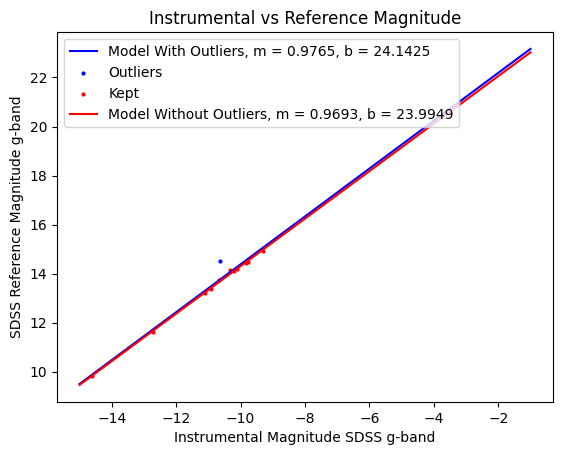

12 12
first try: [ 0.97175198 23.88104041]
second try: [ 0.96387935 23.73049614]


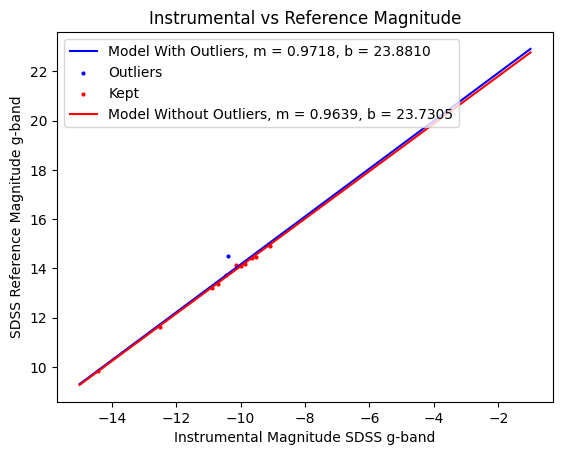

12 12
first try: [ 0.94748647 23.5082359 ]
second try: [ 0.93973318 23.36022744]


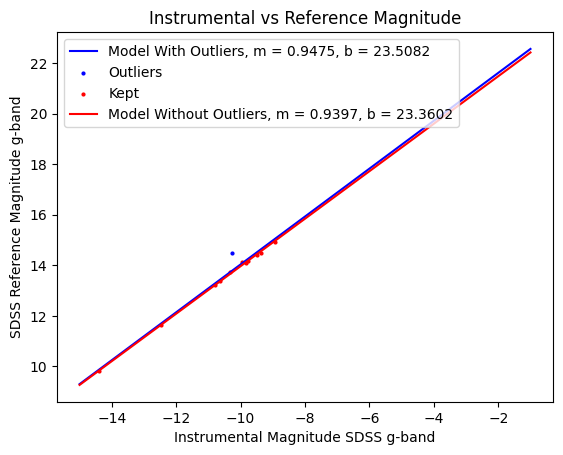

12 12
first try: [ 0.94283563 23.4773865 ]
second try: [ 0.93521515 23.33023627]


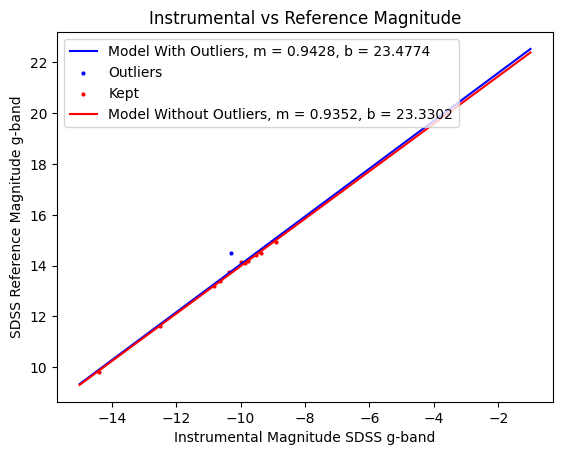

12 12
first try: [ 0.94949934 23.55866297]
second try: [ 0.94184947 23.41101662]


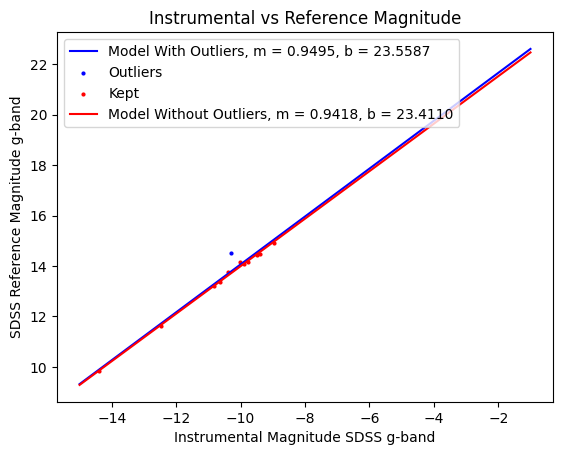

12 12
first try: [ 0.94865729 23.51765169]
second try: [ 0.94127338 23.37207769]


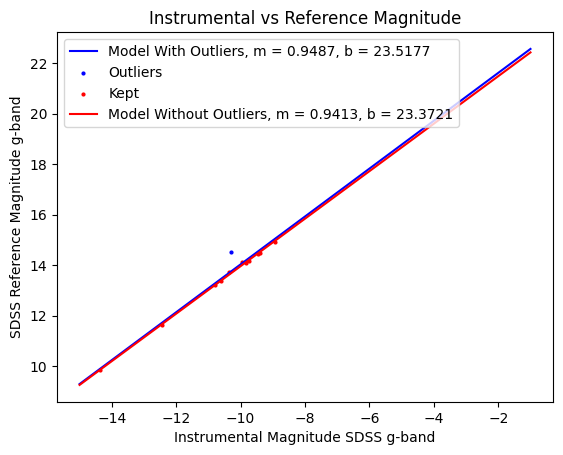

12 12
first try: [ 0.93101507 23.29843973]
second try: [ 0.92340926 23.15219649]


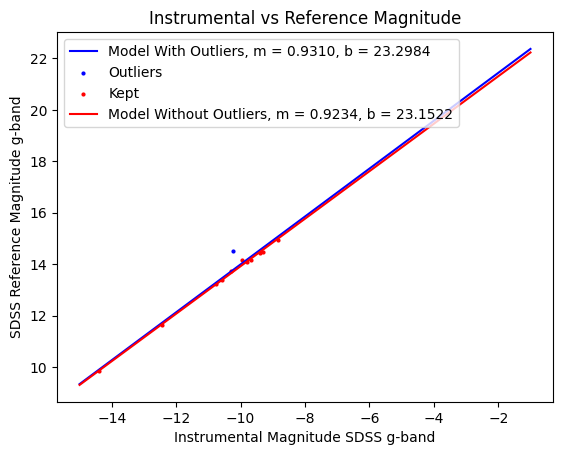

In [94]:
#NEED TO PROPAGATE ERROR FROM THIS SECTION

for set in data:
    res = []
    mag_thresh = 15 #magnitude threshold for picking reference stars

    #criteria for reference stars are that they have an SDSS reference mag, are brighter than the mag threshold and are not outside of the image
    inst_mags = [np.mean(source['instrumental_mags_{}'.format(set['run'])]) for source in sources if source['ref_mag'] != None and source['ref_mag'] < mag_thresh and source['border'] == False]
    sky_mags = [source['ref_mag'][0] for source in sources if source['ref_mag'] != None and source['ref_mag'] < mag_thresh and source['border'] == False]
    #Makes linear model for calibration:
    #This is the first round of modeling, with outliers.
    print(len(inst_mags), len(sky_mags))
    p0 = np.polyfit(inst_mags, sky_mags, deg = 1) #linear fit for instrumental to SDSS mags
    x = np.arange(-15, 0) #plotting fit line
    y = p0[0]*x + p0[1] #fit line
    plt.plot(x, y, color = 'b', label = "Model With Outliers, m = {}, b = {}".format("%.4f" % p0[0], "%.4f" % p0[1] ))
    diffs = [s['ref_mag'][0]- (np.mean(s['instrumental_mags_{}'.format(set['run'])])*p0[0] + p0[1]) for s in sources if s['ref_mag'] != None and s['ref_mag'] < mag_thresh and s['border'] == False]
    stdv = np.std(diffs)

    inst_mags_final = []
    sky_mags_final = []
    outlier_inst =[]
    outlier_sky =[]

    for diff in diffs: #rudementary sigma clipping to remove outliers from calibration model.
        if diff < stdv:
            i = diffs.index(diff)
            inst_mags_final.append(inst_mags[i])
            sky_mags_final.append(sky_mags[i])
        else:
            i = diffs.index(diff)
            outlier_inst.append(inst_mags[i])
            outlier_sky.append(sky_mags[i])
    p1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1) #recalculates calibration model without outliers.
    #p2 = np.polyfit(inst_mags_final, sky_mags_final, deg = 0)
    #print(p2[0])
    print("first try: {}".format(p0)) #prints slopes of each model. In theory, they should come out to around 1.
    print("second try: {}".format(p1))


    plt.scatter(outlier_inst, outlier_sky, color = 'b', s = 4, label = "Outliers")
    plt.scatter(inst_mags_final, sky_mags_final, color = 'r', s = 4, label = "Kept")
    plt.plot(x, [i*p1[0] + p1[1] for i in x], color = 'r', label = "Model Without Outliers, m = {}, b = {}".format("%.4f" % p1[0], "%.4f" % p1[1]))
    #plt.plot(x, [i+ p1[1] for i in x], color = 'g', label = "unity")
    plt.xlabel("Instrumental Magnitude SDSS g-band")
    plt.ylabel("SDSS Reference Magnitude g-band")
    plt.title("Instrumental vs Reference Magnitude")
    plt.legend()
    #plt.savefig("F:/SDI/Section32Figures/calibrationplot.png", dpi = 1000)
    plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/calibrationplot.png", dpi = 1000)
    plt.show()



    #add calibrated mags to sources:
    for source in sources:
        vals = []
        for val in source['instrumental_mags_{}'.format(set['run'])]:
            cal = np.float64(val*p1[0] + p1[1])
            vals.append(cal)
        source['calibrated_mags_{}'.format(set['run'])] = vals #probably a cleaner way to do this part but was having issue where calibrated magnitudes were being added to dict as individual arrays

0
0.43823023089314633 -0.014090625037464832 1.8385132282909207
[[ 1.00744026]
 [-0.03094848]]


/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


56


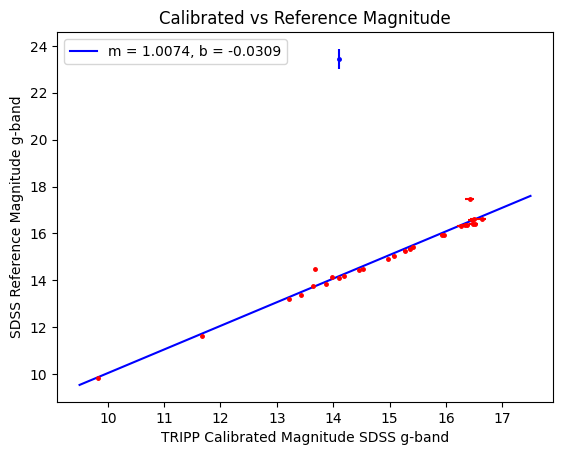

1
0.47821706636420896 -0.0002967620279079597 1.836805298840656
[[ 1.00816765]
 [-0.04327822]]
56


/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/Users/lucaangeleri/PycharmProjects/Process/venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/lucaangeleri/PycharmProje

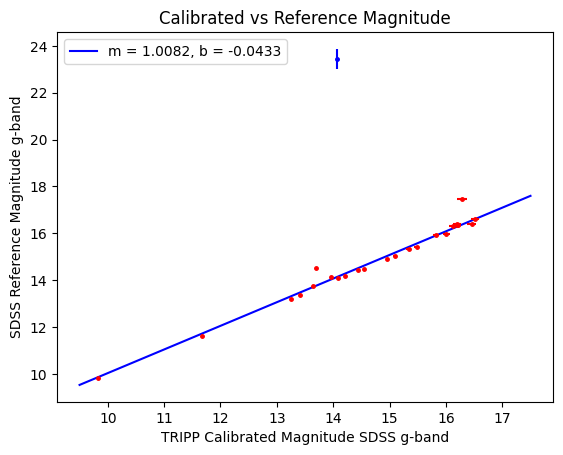

2
0.4215074519876343 -0.019503346045496528 1.8480404418355167
[[ 1.00825052]
 [-0.04472559]]
56


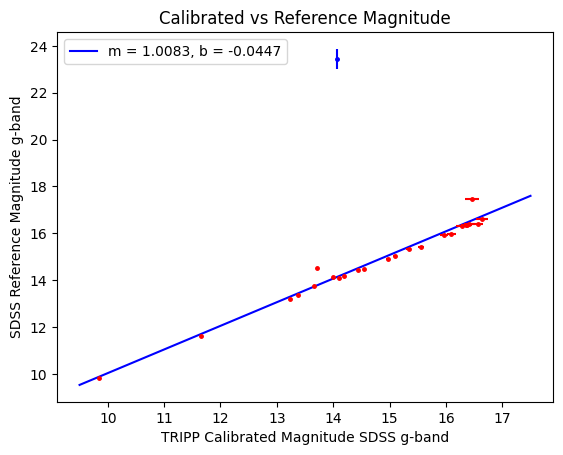

3
0.41211380814185 -0.02108480929669554 1.8463568393279846
[[ 1.00814837]
 [-0.04295312]]
56


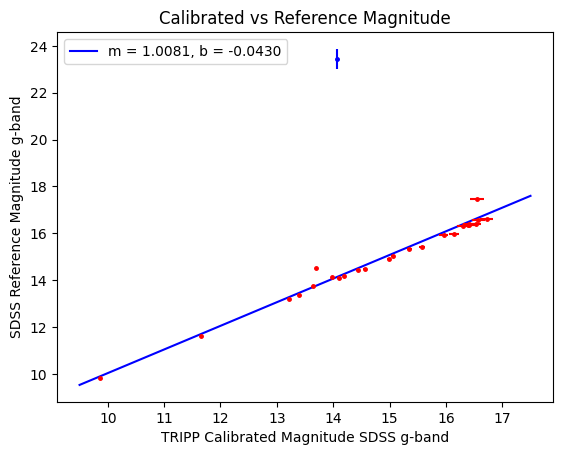

4
0.42006083573122216 -0.024514682779765096 1.8459397385143939
[[ 1.00812219]
 [-0.04250236]]
56


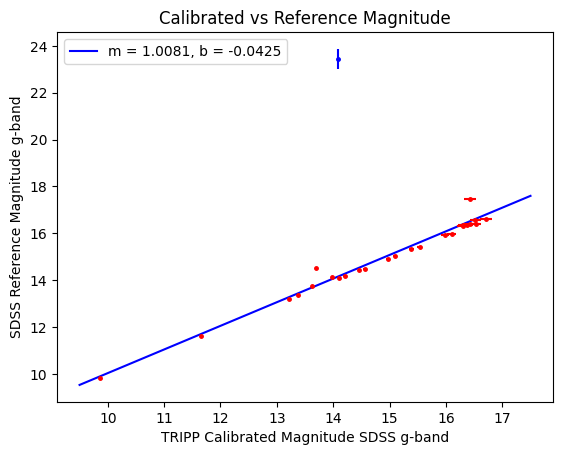

5
0.4031115249876707 -0.044759373860499 1.8479513474402804
[[ 1.0078446 ]
 [-0.03777055]]
56


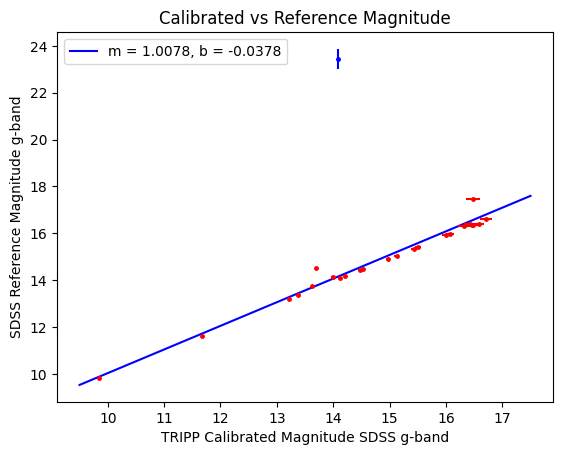

6
0.41825382978322473 -0.02537343513249546 1.8449639456570683
[[ 1.00823667]
 [-0.04445376]]
56


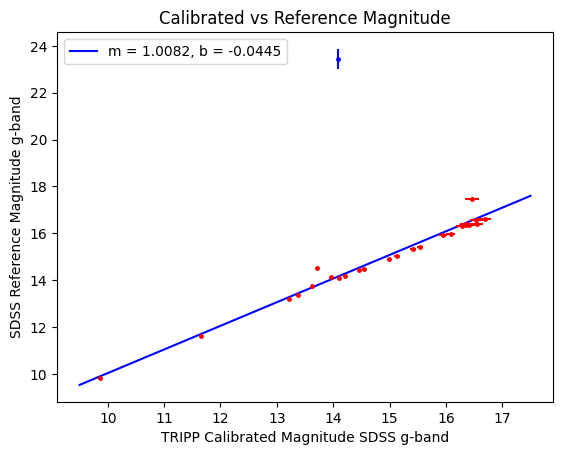

In [95]:
#more plotting just to check stuff, not really necessary for final pipeline but nice to have
for set in data:
    print(set['run'])
    differences = [s['ref_mag']- np.mean(s['calibrated_mags_{}'.format(set['run'])]) for s in sources if s['ref_mag'] != None and s['border'] == False]
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    med_diff = np.median(differences)
    print(mean_diff, med_diff,  std_diff)

    X = [np.mean(s['calibrated_mags_{}'.format(set['run'])]) for s in sources if s['ref_mag'] != None and s['ref_mag'] < mag_thresh and s['border'] == False]
    Y = [s['ref_mag'] for s in sources if s['ref_mag'] != None and s['ref_mag'] < mag_thresh and s['border'] == False]
    p3 = np.polyfit(X, Y, deg = 1)
    x_vals = np.arange(9.5, 18.5)
    plt.plot(x_vals, [x*p3[0] + p3[1] for x in x_vals], color = 'b', label = 'm = {}, b = {}'.format("%.4f" % p3[0], "%.4f" % p3[1]))


    print(p3)

    for s in sources:
        if s['ref_mag'] != None and abs(s['ref_mag'] - np.mean(s['calibrated_mags_{}'.format(set['run'])])) > 3*std_diff:
            plt.errorbar(np.mean(s['calibrated_mags_{}'.format(set['run'])]), s['ref_mag'], xerr= np.median(s['inst_mag_errs_{}'.format(set['run'])]), yerr= s['ref_mag_err'], linestyle = 'none', marker = 'o', markersize = 2.5, color = 'b')
            print(s['source_id'])
        else:
            plt.errorbar(np.mean(s['calibrated_mags_{}'.format(set['run'])]), s['ref_mag'], xerr= np.median(s['inst_mag_errs_{}'.format(set['run'])]), yerr= s['ref_mag_err'], linestyle = 'none', marker = 'o', markersize = 2.5, color = 'r' )



    plt.title("Calibrated vs Reference Magnitude")
    plt.xlabel("TRIPP Calibrated Magnitude SDSS g-band")
    plt.ylabel("SDSS Reference Magnitude g-band")
    plt.legend()
    plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/magdifferences.png", format = 'png', dpi = 1000)
    plt.show()

In [96]:
runs = np.arange(0, len(data))
colors = []
for run in runs: #sets up color scheme for plotting.
    i = 0
    for val in sources[0]['calibrated_mags_{}'.format(run)]:
        i += 1
        colors.append(run)
    print(i)
c = np.array(colors)
colors_options = np.array(['#3B5BA5', '#E87A5D', '#F3B941', '#f00a42', '#6F9BA4', '#9D9EA2', "#C5E86C", "#B4B5DF"]) #HEXIDECIMAL COLORS need to add a ton of colors to this even if they don't all get used. Could set it up do randomly generate hex colors but that will be inconsistent and kinda look like shit.

25
25
25
25
25
25
25


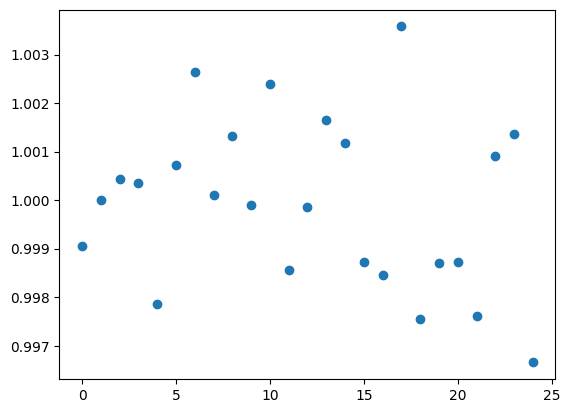

In [101]:
mode = 0
med_dev = True
if med_dev == True: #only run this for single night observing runs. Make part of each night?
    median_curves = []
    for run in runs:
        median_mags = []
        for source in sources:
            median_mags.append(source['calibrated_mags_0'])
        median_curve = np.median(median_mags, axis = 0)/np.median(median_mags) #normalized median light curve
        median_curves.append(median_curve)
    med_curve_final = np.concatenate(median_curves)

p = np.arange(0, len(median_curve))
plt.scatter(p, median_curve)
plt.show()

25
25
25
25
25
25
25
0.08754001836375261


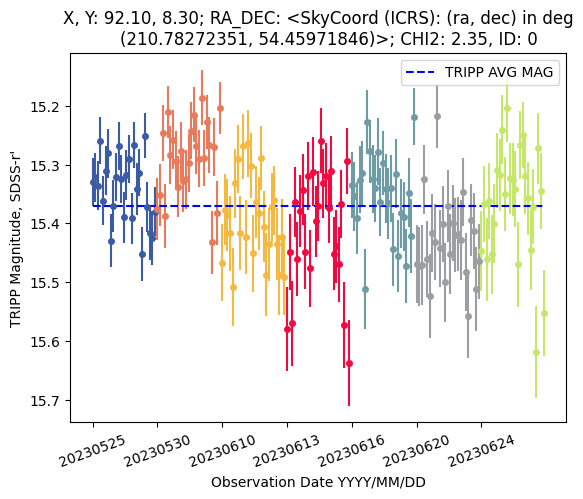

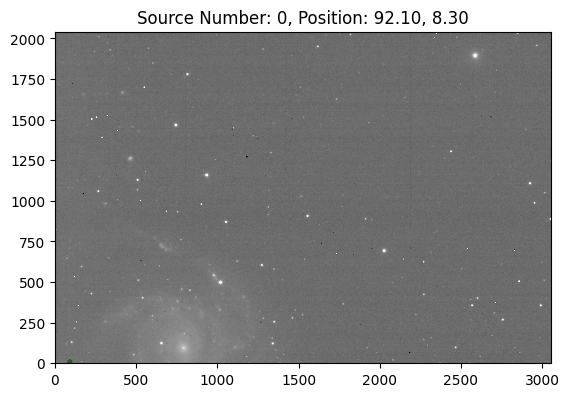

25
25
25
25
25
25
25
0.1087986796704585


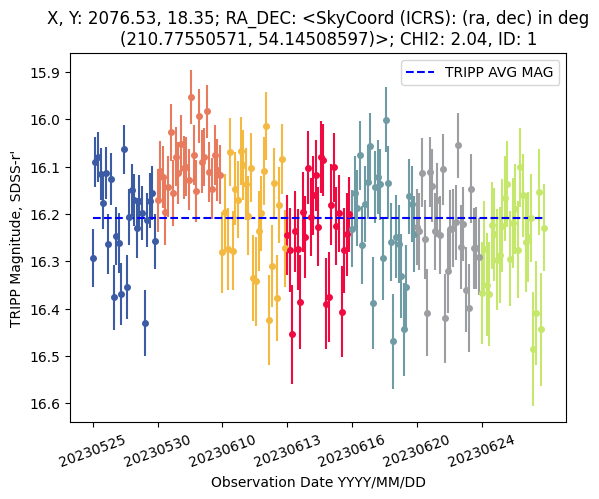

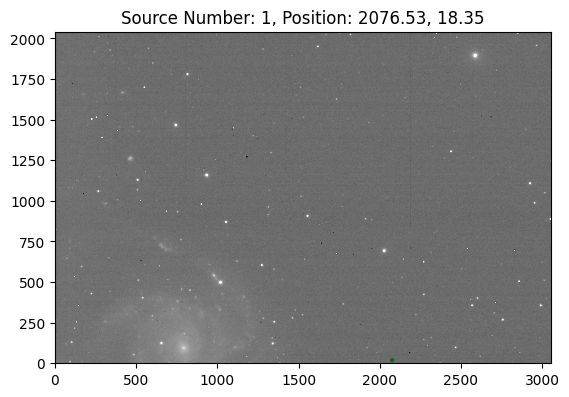

25
25
25
25
25
25
25
0.08490561880655283


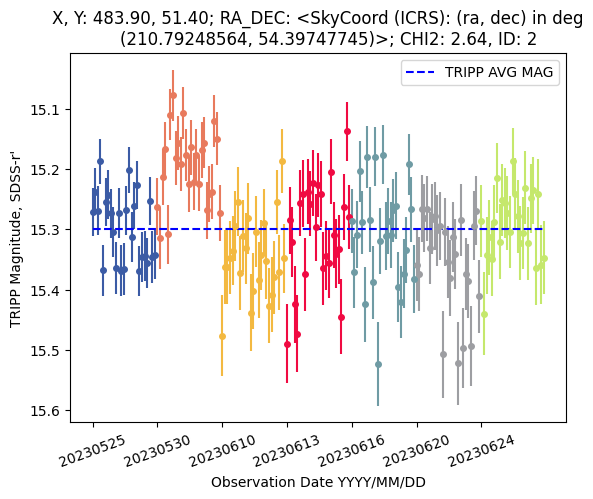

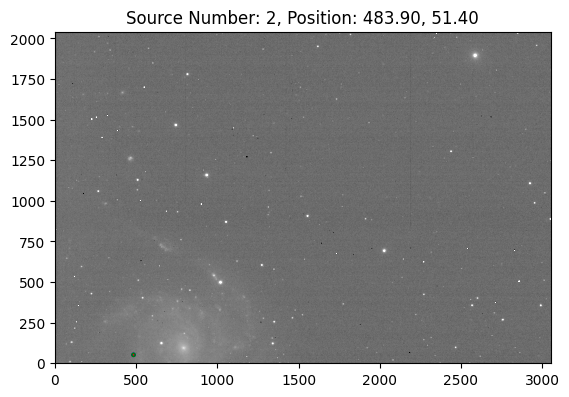

25
25
25
25
25
25
25
0.18921832176950243


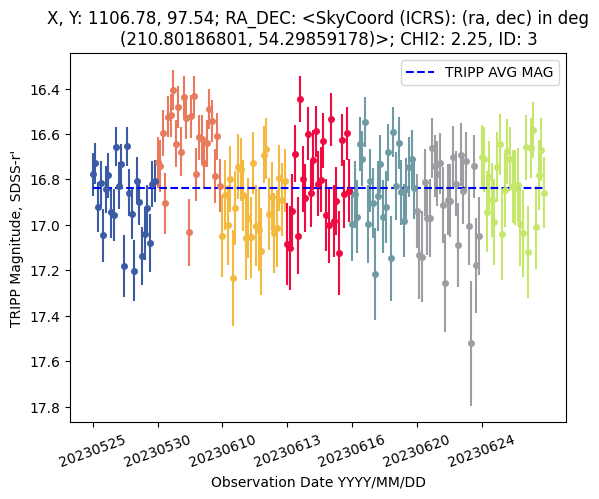

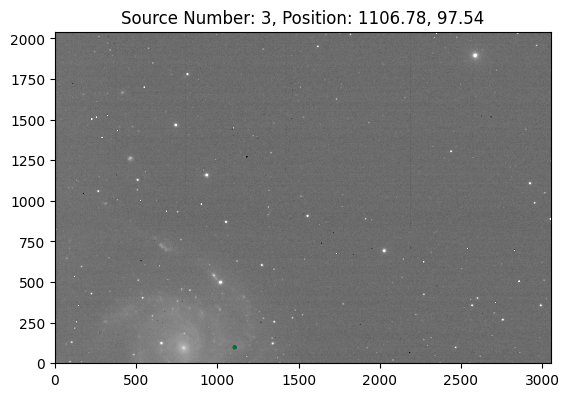

25
25
25
25
25
25
25
0.044145420225910295


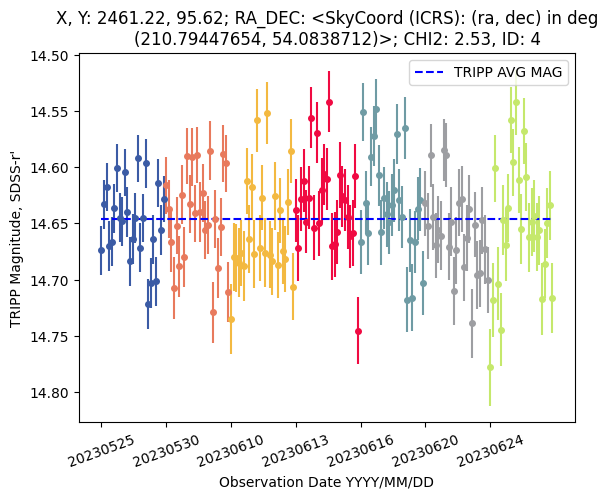

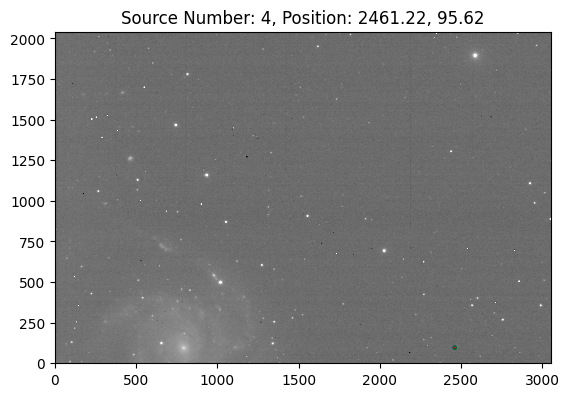

25
25
25
25
25
25
25
0.12143061800358447


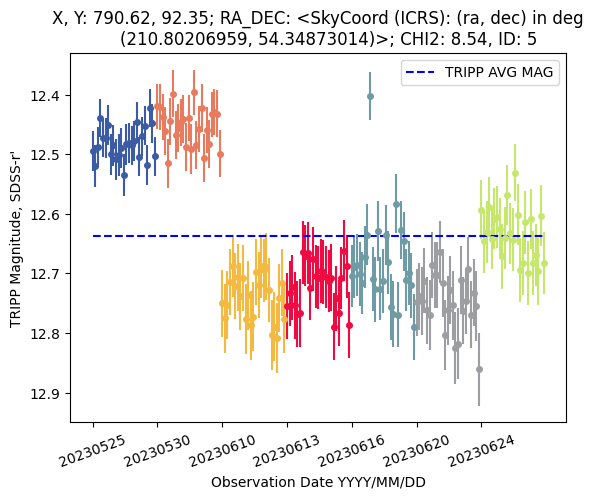

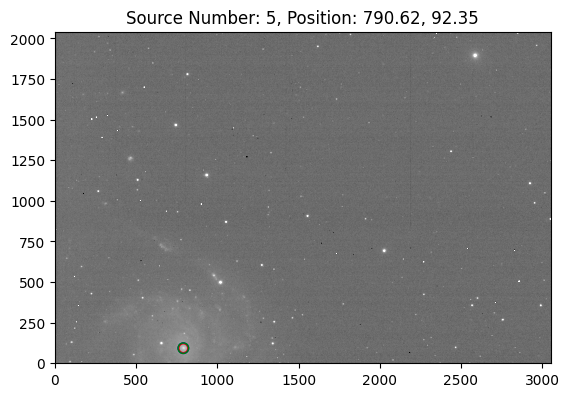

25
25
25
25
25
25
25
0.03508608964595123


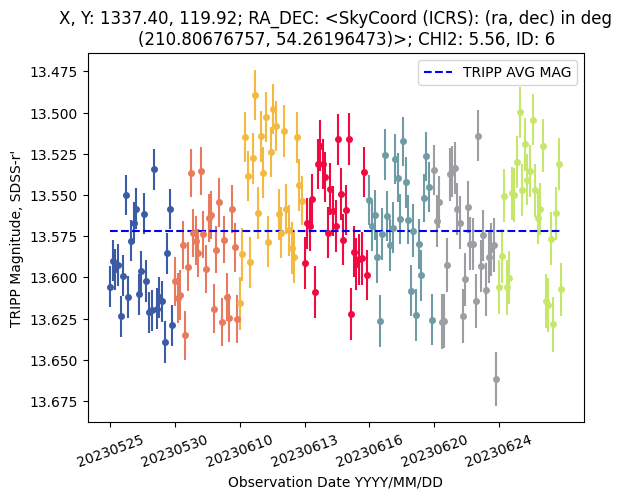

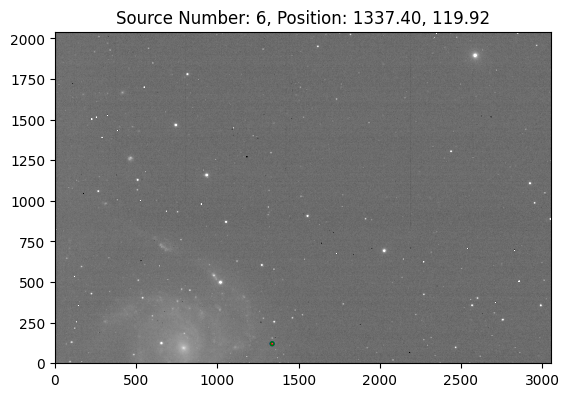

25
25
25
25
25
25
25
0.02996778069027948


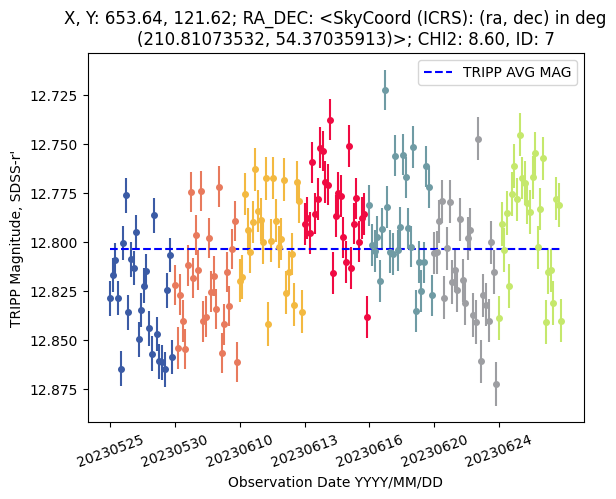

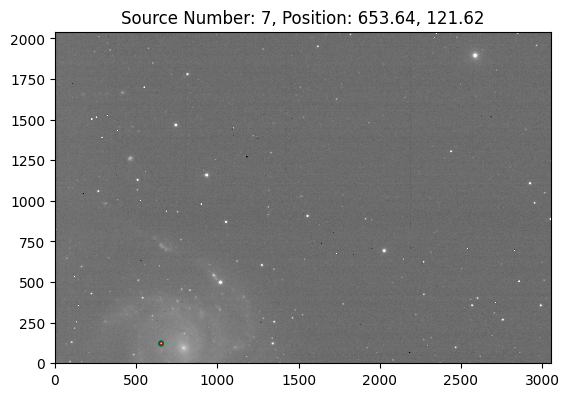

25
25
25
25
25
25
25
0.07362930505234062


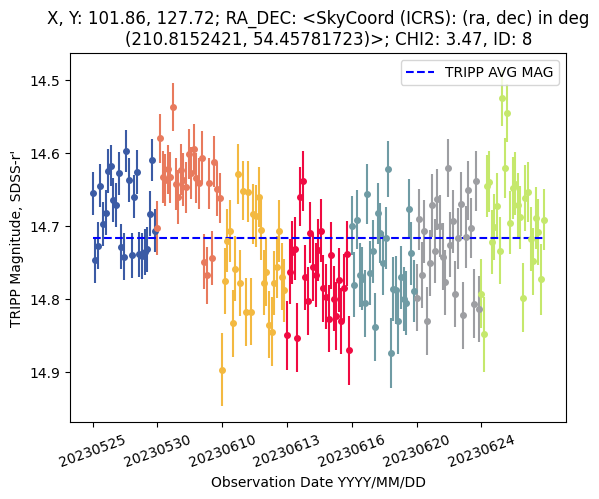

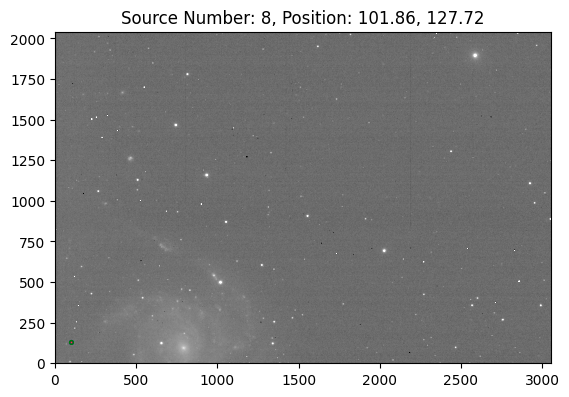

25
25
25
25
25
25
25
0.13095769124748605


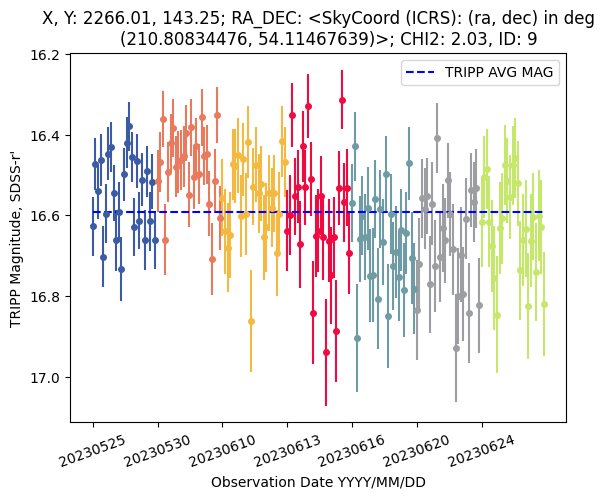

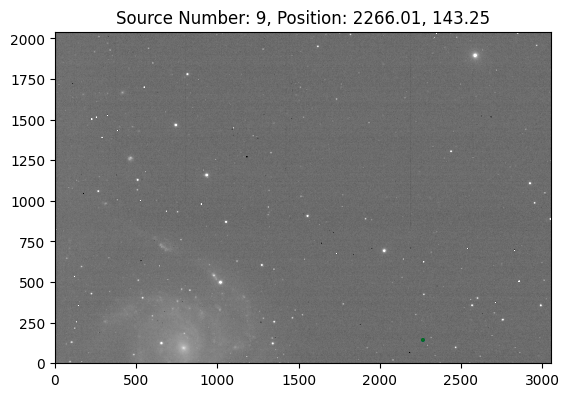

25
25
25
25
25
25
25
0.12574958345770523


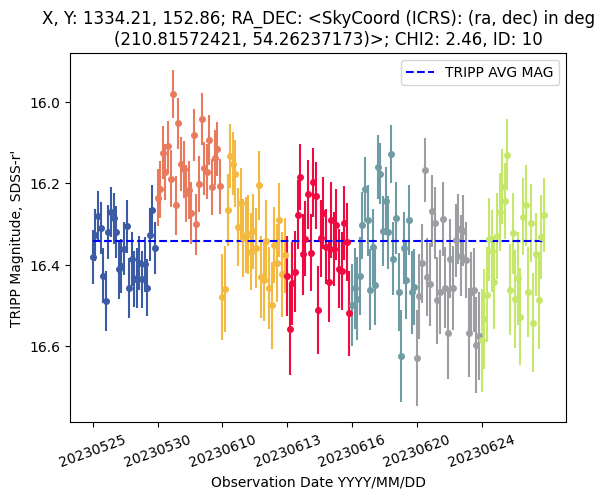

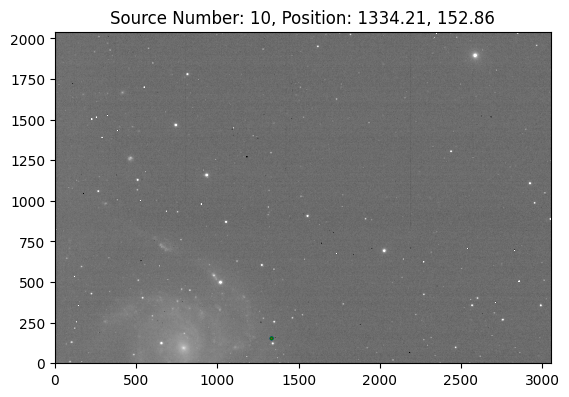

25
25
25
25
25
25
25
0.08645935367320398


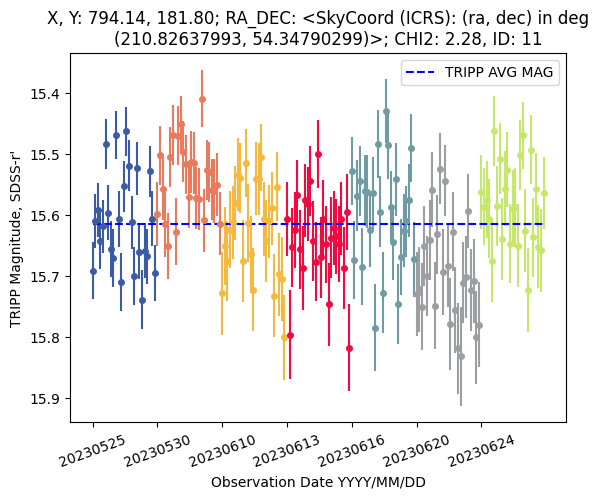

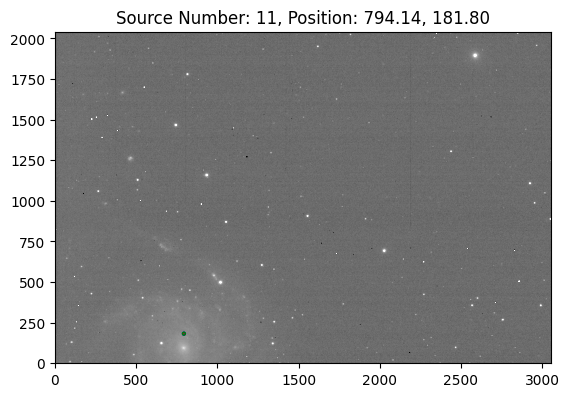

25
25
25
25
25
25
25
0.04206649073171714


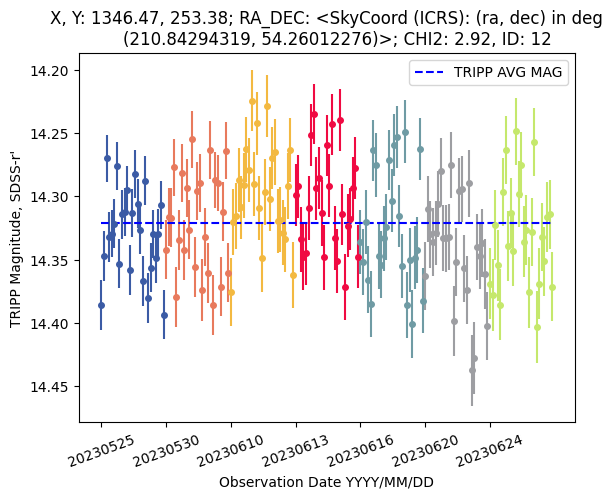

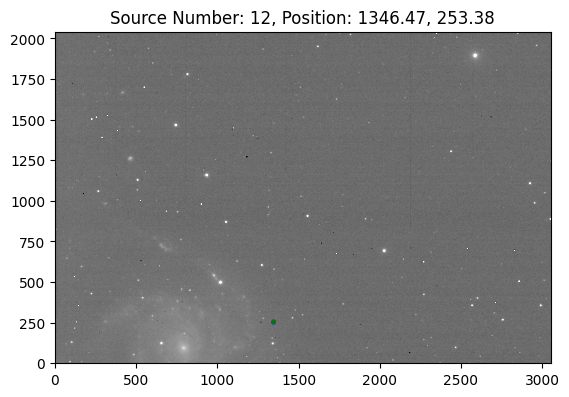

25
25
25
25
25
25
25
0.03797788725209884


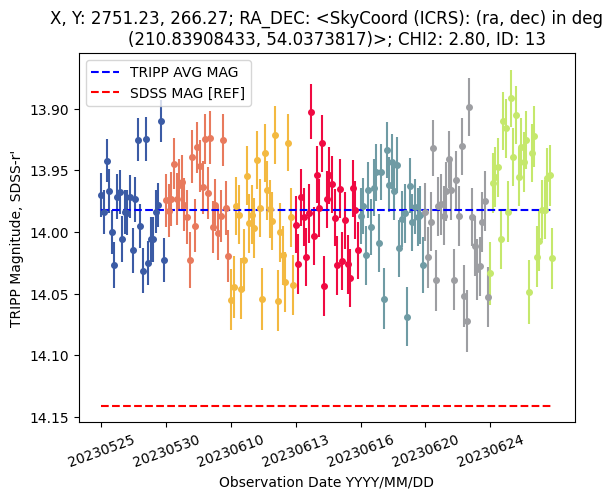

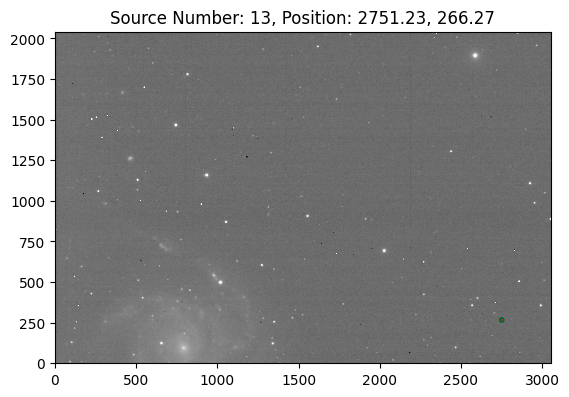

25
25
25
25
25
25
25
0.10720905710999472


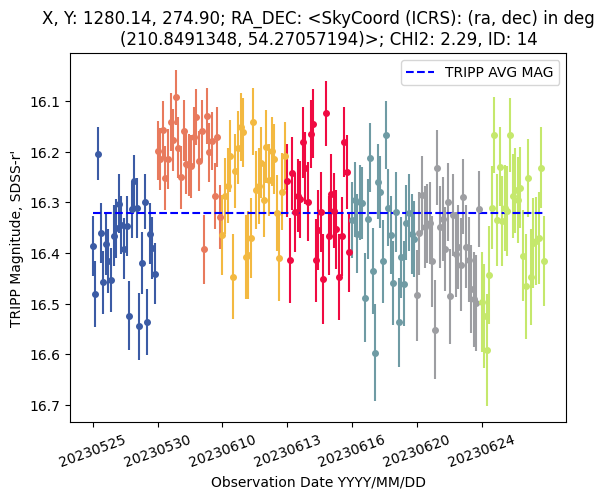

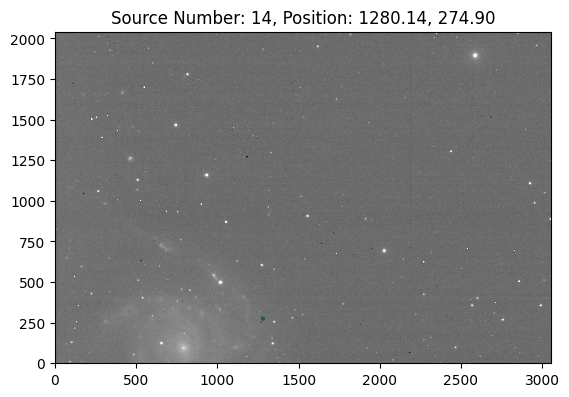

25
25
25
25
25
25
25
0.07053458886278273


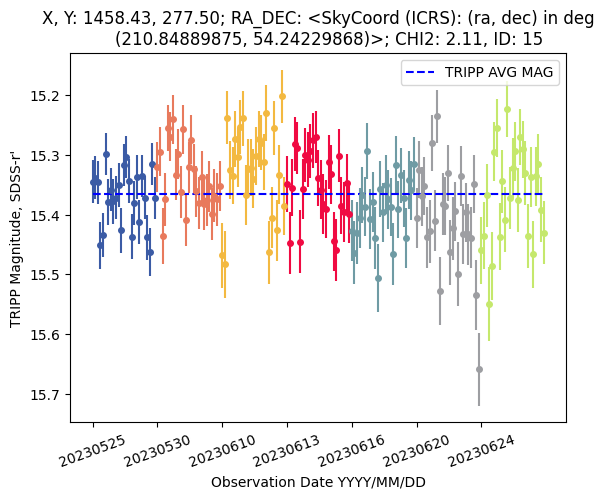

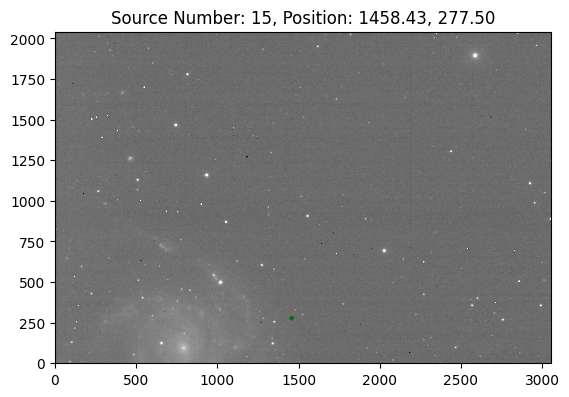

25
25
25
25
25
25
25
0.07857795429396712


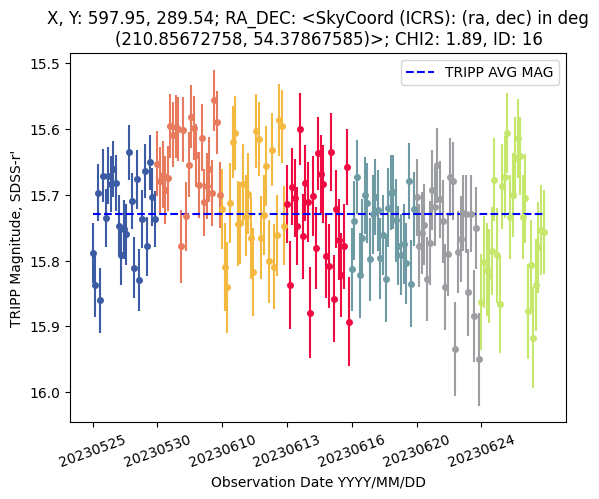

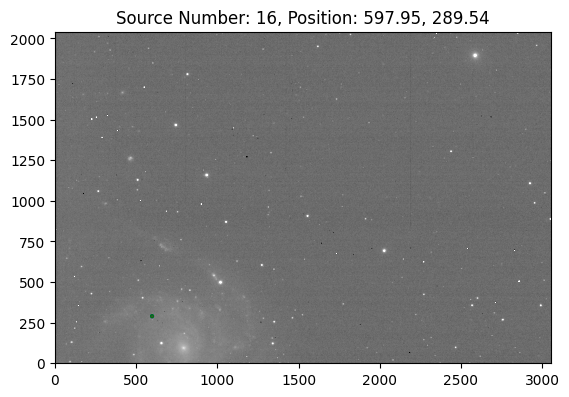

25
25
25
25
25
25
25
0.10936221967534444


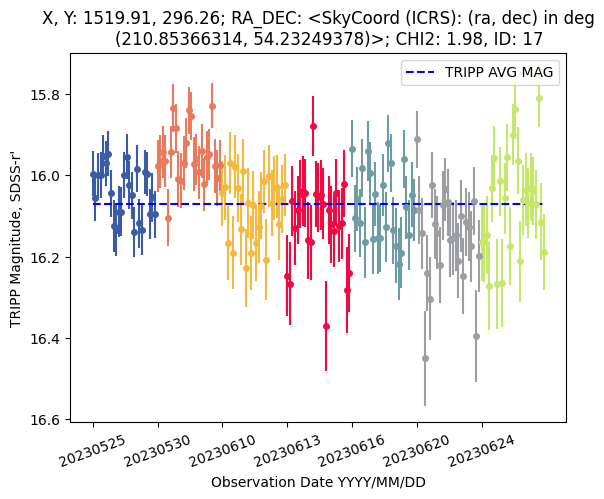

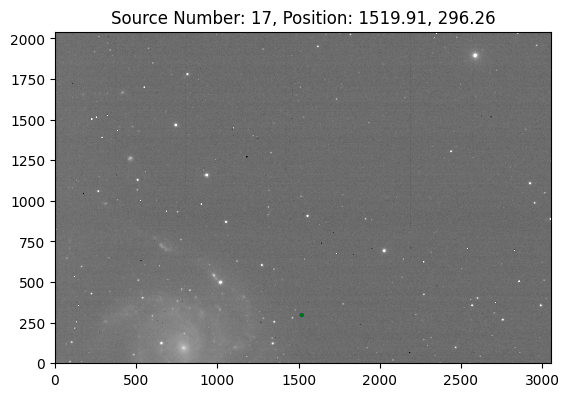

25
25
25
25
25
25
25
0.11091078164280883


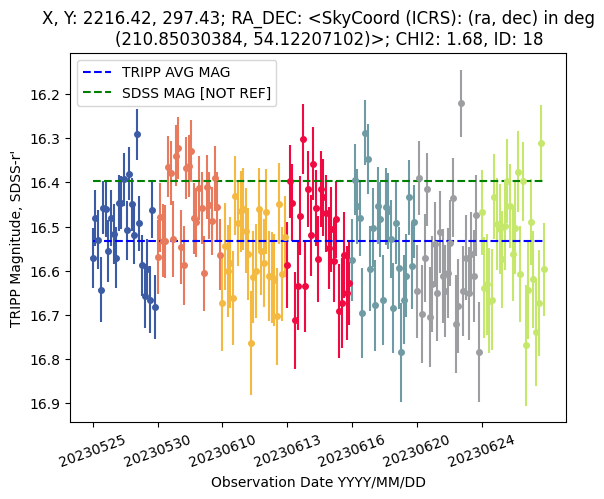

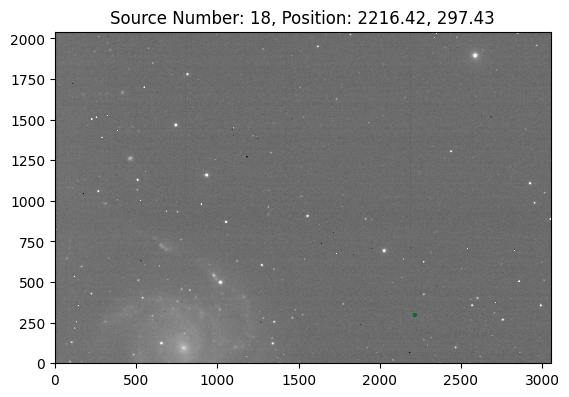

25
25
25
25
25
25
25
0.14888017421382177


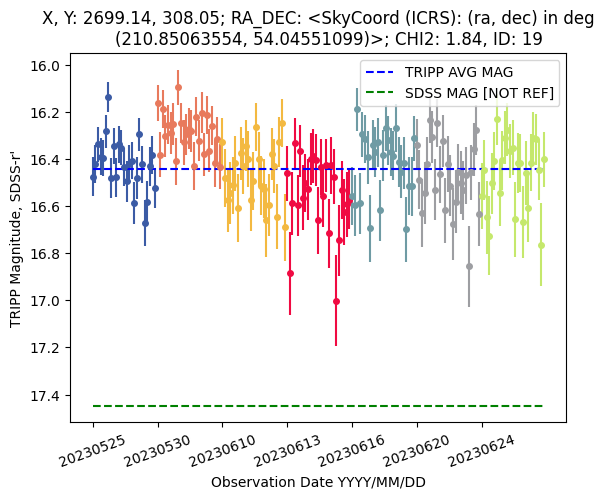

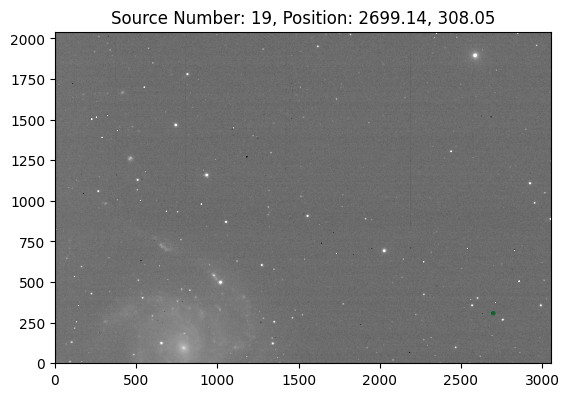

25
25
25
25
25
25
25
0.20172262095824176


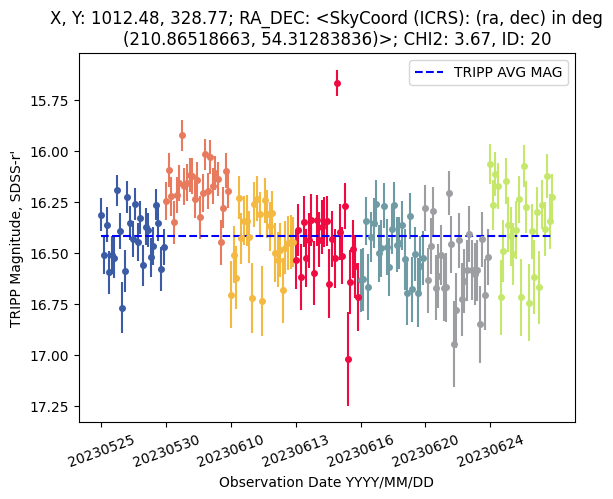

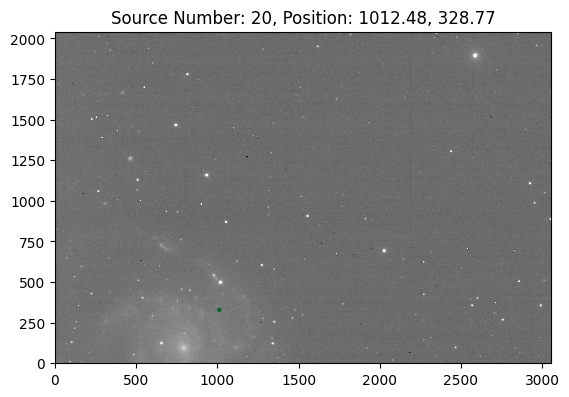

25
25
25
25
25
25
25
0.19230579201766257


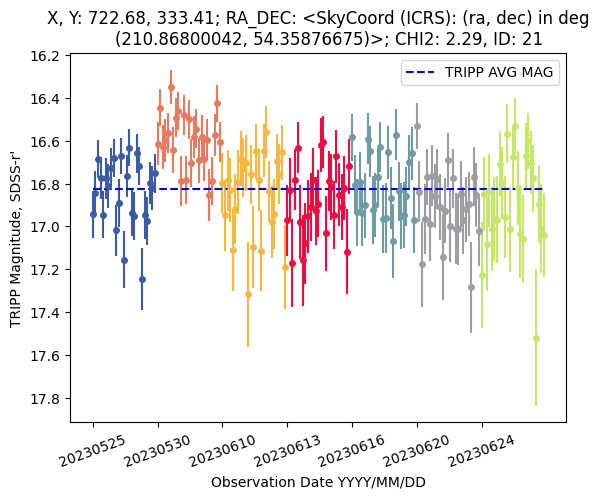

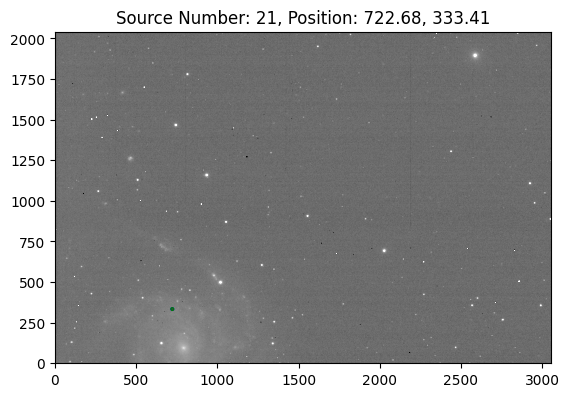

25
25
25
25
25
25
25
0.03734288604296654


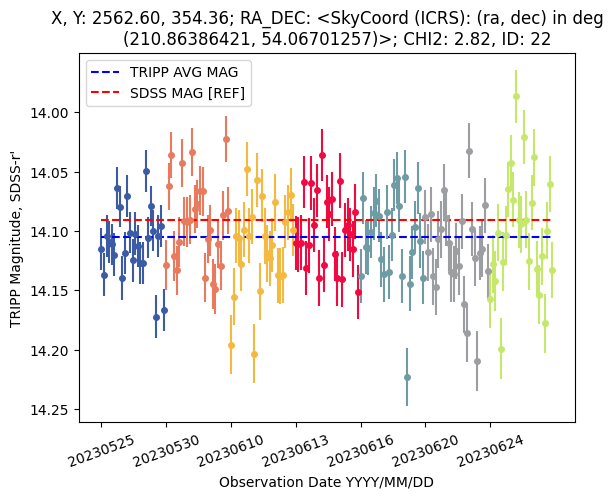

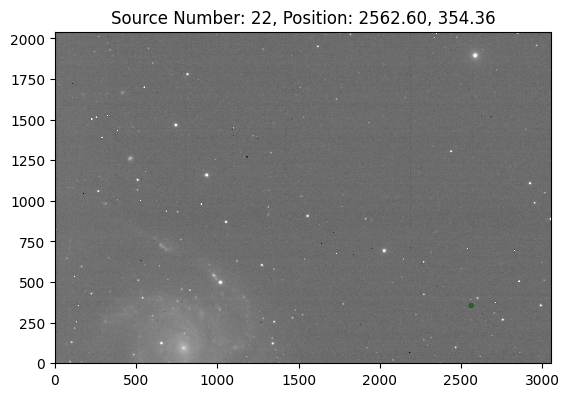

25
25
25
25
25
25
25
0.035590693847608684


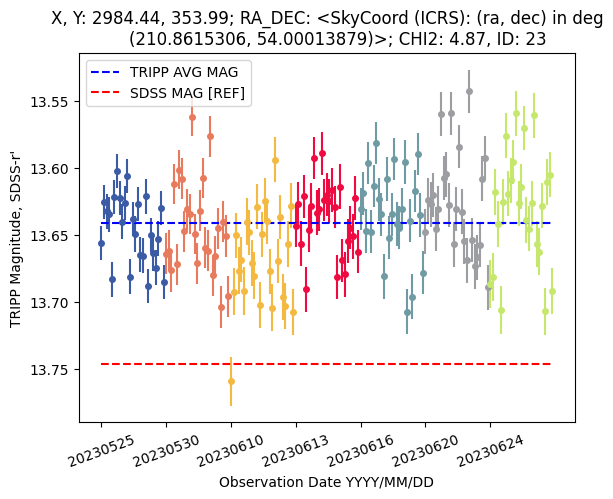

In [ ]:

transient_candidates = []
#plots light curves.
for source in sources:
    x, y = SkyCoord.to_pixel(source['ra_dec'], wcs= data[0]['WCS'])
    tick_locs = []
    if mode == 0:
        MAGS = np.concatenate([source['calibrated_mags_{}'.format(i)] for i in runs if source['border'] == False])
        ERRS = np.concatenate([source['inst_mag_errs_{}'.format(i)] for i in runs if source['border'] == False])
        r = np.arange(0, len(MAGS), 1)
        set_counter = 0
        for i, val in enumerate(MAGS):
            if len(data) > 1 and i % len(data[set_counter]['images']) == 0: #THIS WILL ONLY WORK IF ALL SETS HAVE 25 FRAMES. Need to make it dynamic in case different nights don't have the same number of images.
                print(len(data[set_counter]['images']))
                plt.errorbar(i, val/med_curve_final[i], yerr = ERRS[i], linestyle = 'none', marker = 'o', markersize = 4,  c = colors_options[c][i])
                tick_locs.append(i)
                if set_counter < len(data) -1: #prevents counter from over indexing data
                    set_counter += 1
            else:
                plt.errorbar(i, val/med_curve_final[i], yerr = ERRS[i], linestyle = 'none', marker = 'o', markersize = 4, c = colors_options[c][i])
        if len(data) > 1:
            plt.xticks(tick_locs, [data[i]['header']['DAY-OBS'] for i in runs], rotation = 20)


    if mode == 1:
        MAGS = [np.median(source['calibrated_mags_{}'.format(i)]) for i in runs if source['border'] == False]
        ERRS = [np.median(source['inst_mag_errs_{}'.format(i)]) for i in runs if source['border'] == False]
        r = np.arange(0, len(MAGS), 1)
        for i, mag in enumerate(MAGS):
            plt.errorbar(i, mag, yerr = ERRS[i], linestyle = 'none', marker = 'o', markersize = 4, c = colors_options[r][i])
            tick_locs.append(i)
        plt.xticks(tick_locs, [data[i]['header']['DAY-OBS'] for i in runs], rotation = 20)

    Chis = []
    avg_mag = np.mean(MAGS/med_curve_final)
    for i, m in enumerate(MAGS):
        chi_i = (((m/med_curve_final[i]) - avg_mag)**2)/(ERRS[i]**2)
        Chis.append(chi_i)
    dof = len(MAGS) - 1
    chi_dof = np.sum(Chis)/dof

    #transient/variable detection:
    dev = np.std(MAGS/med_curve_final)
    print(dev)


    #plt.title("X, Y: {}, {}; RA, DEC: {}, {}, CHI2: {}, ID: {}".format("%.2f" % source['x_coord'],"%.2f" % source['y_coord'],"%.4f" % source['ra'][0],"%.4f" % source['dec'][0], "%.2f" %chi_dof, source['source_id'] )) #get only to display a few decimal places
    plt.title("X, Y: {}, {}; RA_DEC: {}; CHI2: {}, ID: {}".format("%.2f" % x,"%.2f" % y, source['ra_dec'], "%.2f" %chi_dof, source['source_id'] ))
    plt.plot(r, np.ones(len(r))*avg_mag, label = "TRIPP AVG MAG", linestyle = '--', color = 'b')
    if source['ref_mag'] != None:
        if source['ref_mag'] < 16:
            plt.plot(r, np.ones(len(r))*source['ref_mag'], linestyle = '--', color = 'r', label = "SDSS MAG [REF]" )
        if source['ref_mag'] >= 16:
            plt.plot(r, np.ones(len(r))*source['ref_mag'], linestyle = '--', color = 'g', label = "SDSS MAG [NOT REF]" )
    plt.ylabel("TRIPP Magnitude, SDSS-{}'".format(filter))
    plt.xlabel("Observation Date YYYY/MM/DD")
    plt.legend()
    #plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/Source{}lightcurve.png".format(source['source_id']), format = 'png', dpi = 500,  bbox_inches="tight")
    plt.gca().invert_yaxis()
    plt.show()



    plt.title("Source Number: {}, Position: {}, {}".format(source['source_id'], "%.2f" % x, "%.2f" % y))
    circle0 = plt.Circle((x, y), source['rad'], color = 'r', fill = False)
    circle1 = plt.Circle((x, y), source['rad'] + 5, color = 'b', fill = False)
    circle2 = plt.Circle((x,y), source['rad'] +5, color = 'g',fill = False)
    ax = plt.gca()
    ax.add_patch(circle0)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    plt.imshow(data[0]['template'], cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 200), origin='lower')
    #plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/Source{}location.png".format(source['source_id']), format = 'png', dpi = 500,  bbox_inches="tight")
    plt.show()






